In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
# import the data into dataframe
df_o = pd.read_csv("merge_data.csv", low_memory=False)

In [5]:
# make the copy of the dataframe
df = df_o.copy()

In [6]:
# checking the missing values 
df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

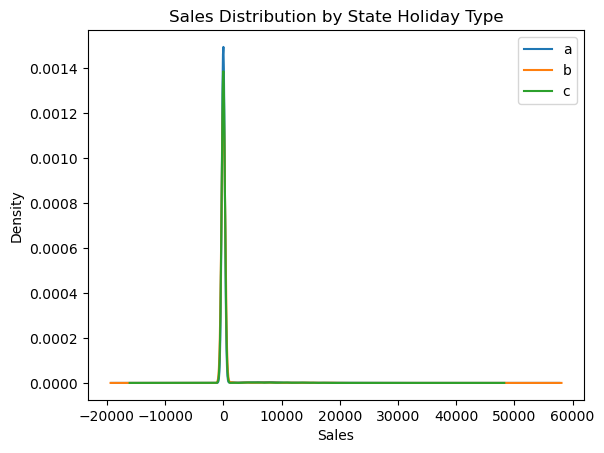

In [7]:
# Plotting the sales distribution for StateHoliday type "a", "b" 'c'.
df[df["StateHoliday"]=="a"]["Sales"].plot(kind="kde", label="a")
df[df["StateHoliday"]=="b"]["Sales"].plot(kind="kde", label="b")
df[df["StateHoliday"]=="c"]["Sales"].plot(kind="kde", label="c")
# Adding a legend to differentiate between the state holiday types.
plt.legend()
plt.title("Sales Distribution by State Holiday Type")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.show()

The distributions of the sales for the different state holidays ('a', 'b', 'c') are indeed very similar, it may be wise to combine them into a single category for simplicity,

In [8]:
# combining the different kind of stateholiday 
df["StateHoliday"]=df["StateHoliday"].replace({"a":1, "b":1, 'c':1})
df["StateHoliday"]= df["StateHoliday"].astype(float)

In [9]:
# convert the date column to datetime and extract the hierarchy of date as column
df["Date"]=pd.to_datetime(df["Date"], infer_datetime_format=True)
df['MonthNumber'] = df['Date'].dt.strftime('%m').astype(int)
#df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year
# Extract Year, Month, and WeekOfYear from 'Date'
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

In [10]:
# set the date as index and drop the unnecessary column
df=df.set_index("Date").drop(columns=["Store", "Customers"])
# filter the df to include only where the "Open" column is 1.
df=df[df["Open"]==1]

# Creating function that will fit and evaluate different type of model

In [25]:
#Columns needed to compare metrics
comparison_columns = ['Model_Name', 'Train_MAE', 'Train_MSE', 'Train_RMSE', 'Train_R2' ,'Test_MAE', 'Test_MSE', 'Test_RMSE'
                    #  , 'Test_R2', 'Test_Adj_R2' , 'Train_Adj_R2'
                     ]




def model_and_evaluation(model_name, model_variable,X, k):
    X_train, X_test, y_train, y_test = train_test_split(X, k, test_size=0.3, random_state=42)
    
    
    scaler = StandardScaler() # Initialize the scaler
    scaler.fit(X_train)

    # Transform the training data
    X_train_scaled = scaler.transform(X_train)

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)

    model = model_variable.fit(X_train_scaled,y_train)
    train_predict=model_variable.predict(X_train_scaled)
    test_predict=model_variable.predict(X_test_scaled)
    
       #calculate metrics and print the results for test set
    #Mean Absolute Error or MAE
    MAE_train = round(mean_absolute_error(y_train,train_predict),6)
    MAE_test = round(mean_absolute_error(y_test,test_predict),6)
    #Mean Squared Error or MSE
    MSE_train = round(mean_squared_error(y_train,train_predict),6)
    MSE_test = round(mean_squared_error(y_test,test_predict),6)
    #Root Mean Squared Error or RMSE
    RMSE_train = round(mean_squared_error(y_train,train_predict,squared=False),6)
    RMSE_test = round(mean_squared_error(y_test,test_predict,squared=False),6)
    #R2
    R2_train = round(r2_score(y_train, train_predict),6)
    R2_test = round(r2_score(y_test, test_predict),6)
    #Adjusted R2
   # Adj_r2_train = round(1 - (1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-x_train.shape[1]-1),6)
    #Adj_r2_test = round(1 - (1-r2_score(y_val, y_pred_test)) * (len(y_val)-1)/(len(y_val)-x_val.shape[1]-1),6)

    #printing test results
    print(f'The Mean Absolute Error for the validation set is {MAE_test}')
    print(f'The Mean Squared Error for the validation set is {MSE_test}')
    print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
    print(f'The R^2 for the validation set is {R2_test}')
  #  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')


    plot_df=pd.DataFrame({ "Sales":y_test, "predicted sales":test_predict}, index=y_test.index,)
    # Aggregate data monthly to reduce noise
    plot_df = plot_df.resample('M').sum()

    # Plot the test results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_df)
    plt.ylabel("Total Sales and Predicted Sales")
    plt.xticks(rotation=45)
    plt.title(f'{model_name} - Sales vs Predicted Sales')
    plt.legend(labels=['Sales', 'Pred Sales'])
    plt.grid(axis="y")
    plt.show()  
    
    
    # Saving our results
    metric_scores = [model_name, MAE_train, MSE_train, RMSE_train, R2_train, MAE_test, MSE_test, RMSE_test,
                     #R2_test, Adj_r2_test, Adj_r2_train
                    ]
    final_dict = dict(zip(comparison_columns, metric_scores))
   # return [final_dict]

    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame([final_dict])
    return comparison_df

In [26]:
# split the df into features and target
X_1=df.copy()
y = X_1.pop("Sales")
# onverting each category into a new binary column (dummy variable),
X_dummied=pd.get_dummies(X_1, columns=["StoreType", "Assortment", "PromoInterval"], drop_first=True)

# Model without Features Engineering

The Mean Absolute Error for the validation set is 849.703827
The Mean Squared Error for the validation set is 1792887.002603
The Root Mean Squared Error for the validation set is 1338.987305
The R^2 for the validation set is 0.813612


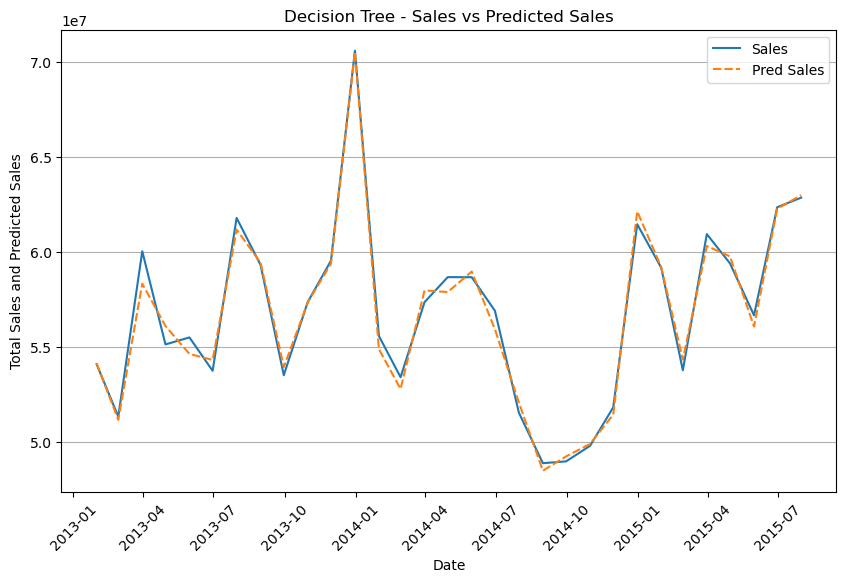

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,6.193732,13437.829642,115.921653,0.998607,849.703827,1.792887e+06,1338.987305


In [27]:
dt_basic = DecisionTreeRegressor(random_state=42) # Initialize the tree base model
model_and_evaluation("Decision Tree",dt_basic, X_dummied, y)

The Mean Absolute Error for the validation set is 650.304934
The Mean Squared Error for the validation set is 1022154.448195
The Root Mean Squared Error for the validation set is 1011.016542
The R^2 for the validation set is 0.893737


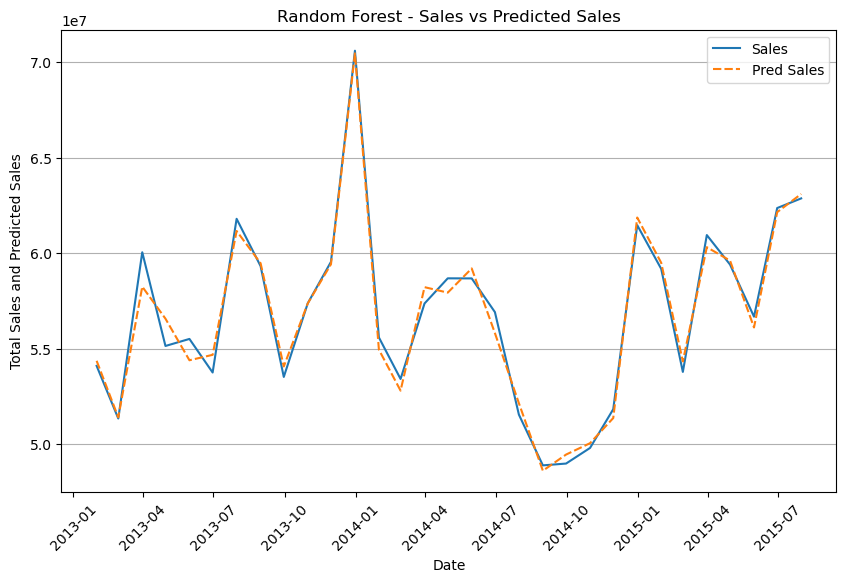

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,244.611398,153076.463391,391.249873,0.984126,650.304934,1.022154e+06,1011.016542


In [28]:
rf_basic = RandomForestRegressor(random_state=42) # Initialize the random forest base model
model_and_evaluation("Random Forest",rf_basic, X_dummied, y)

# Model with Feature selection using RFE Technique 

In [29]:
# Initialize a Linear Regression model to be used as the estimator for feature selection.
model = LinearRegression()

# Apply Recursive Feature Elimination (RFE) to select the top 15 most important features.
# RFE works by recursively fitting the model and removing the least important feature until the desired number of features is reached.
recursion = RFE(estimator=model, n_features_to_select=15)

# Fit the RFE model on the dataset (X_dummied) with the target variable (y).
recursion.fit(X_dummied, y)

# Extract the names of the columns (features) that were selected by RFE.
columns = X_dummied.columns[recursion.support_]

# Create a new DataFrame (new_X) that contains only the selected features.
new_X = X_dummied[columns]


The Mean Absolute Error for the validation set is 1827.683109
The Mean Squared Error for the validation set is 6568356.252233
The Root Mean Squared Error for the validation set is 2562.88046
The R^2 for the validation set is 0.317157


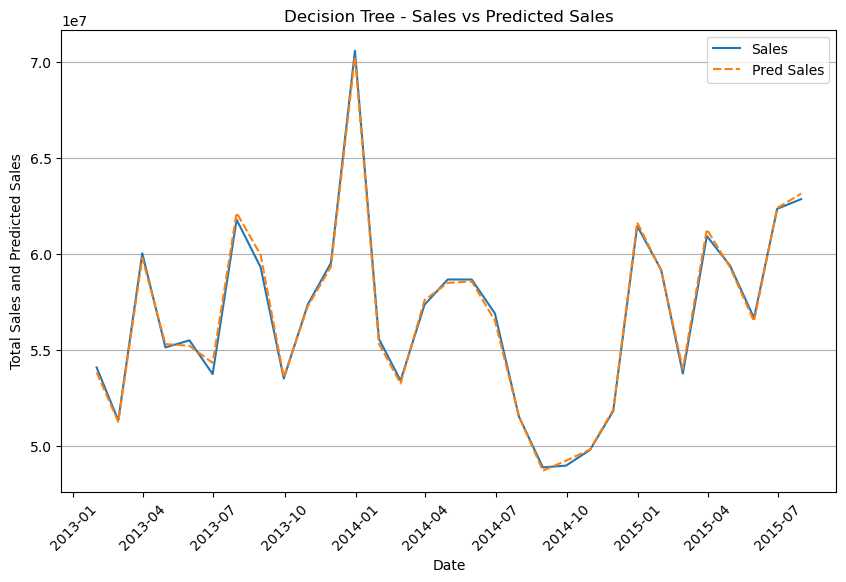

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,1689.591926,5.856016e+06,2419.920734,0.392744,1827.683109,6.568356e+06,2562.88046


In [30]:
model_and_evaluation("Decision Tree",dt_basic, new_X, y)

The Mean Absolute Error for the validation set is 1814.883486
The Mean Squared Error for the validation set is 6495010.666536
The Root Mean Squared Error for the validation set is 2548.53108
The R^2 for the validation set is 0.324782


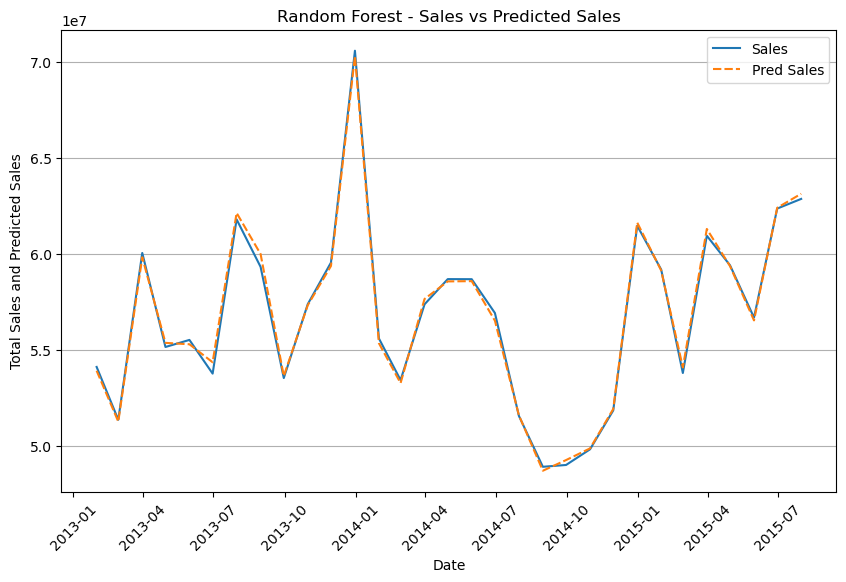

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,1697.856003,5.866091e+06,2422.001382,0.391699,1814.883486,6.495011e+06,2548.53108


In [31]:
model_and_evaluation("Random Forest",rf_basic, new_X, y)

# Model with Feature selection using backward elimination Technique 

In [43]:
# Perform backward elimination
def backward_elimination(X, y, significance_level=0.05):
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_variable = p_values.idxmax()
            X = X.drop(columns=excluded_variable)
        else:
            break
    return model

final_model = backward_elimination(y, X_1)

print(final_model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [42]:
X_1

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthNumber,Year,WeekOfYear
Date,,,,,,,,,,,,,,,,,
2015-07-31,5,1,1,0.0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,7,2015,31
2015-07-31,5,1,1,0.0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,31
2015-07-31,5,1,1,0.0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,31
2015-07-31,5,1,1,0.0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,7,2015,31
2015-07-31,5,1,1,0.0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,2,1,0,1.0,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0,1,2013,1
2013-01-01,2,1,0,1.0,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0,1,2013,1
2013-01-01,2,1,0,1.0,1,b,b,840.0,9.0,2013.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,2013,1


# Feature Engineering 

In [208]:
df1 = df.copy()

In [209]:
#combining competition open since month and year into total months
df1['CompetitionOpen'] = (df1['Year'] - df1['CompetitionOpenSinceYear'])*12 + (df1['MonthNumber'] - df1['CompetitionOpenSinceMonth'])
#correcting the neg values
df1['CompetitionOpen'] = df1['CompetitionOpen'].apply(lambda x:0 if x < 0 else x)
#dropping both the columns
df1.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], axis=1,inplace=True)

In [210]:
#changing promo2 features into meaningful inputs
#combining promo2 to total months

# Calculate Promo2Open
df1['Promo2Open'] = (df1['Year'] - df1['Promo2SinceYear']) * 12 + (df1['WeekOfYear'] - df1['Promo2SinceWeek']) * 0.230137

# Correct negative values
df1['Promo2Open'] = df1['Promo2Open'].apply(lambda x: 0 if x < 0 else x) * df1['Promo2']

# Create a function to check if Promo2 was running in the sale month
def promo2running(row):
    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    try:
        months = row['PromoInterval'].split(',')
        if month_dict[row['MonthNumber']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

# Apply the function
df1['Promo2running'] = df1.apply(promo2running, axis=1) * df1['Promo2']

In [211]:
# Create a dictionary to map month numbers to their corresponding string values
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Define a function to check if the promotion is active for the given month
def is_promo_active(promo_interval, month_num):
    if pd.isna(promo_interval):
        return 0
    # Get the month string for the corresponding month number
    month_str = month_map[month_num]
    # Check if the month string is in the PromoInterval list
    return int(month_str in promo_interval.split(','))

# Apply the function vectorized using numpy's vectorize
df1['promo2active'] = np.vectorize(is_promo_active)(df1['PromoInterval'], df1['MonthNumber'])

In [212]:
# # Create a function to check if Promo2 was running in the sale month
# def promo2running(row):
#     month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
#     try:
#         months = row['PromoInterval'].split(',')
#         if month_dict[row['MonthNumber']] in months:
#             return 1
#         else:
#             return 0
#     except Exception:
#         return 0

# # Apply the function
# #df1['Promo2running'] = df1.apply(promo2running, axis=1) * df1['Promo2']



In [213]:
# Drop unnecessary columns
df1.drop(['Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval'], axis=1, inplace=True)

# Outliers Check using z_score Technique

In [214]:
# #code to seperate outliers
# # Calculate mean and standard deviation of Sales
# mean_sales = np.mean(df1['Sales'])
# sd_sales = np.std(df1['Sales'])

# # Define the threshold for identifying outliers
# threshold = 3

# # Identify outliers
# outliers = []
# for value in df1['Sales']:
#     z_score = (value - mean_sales) / sd_sales
#     if z_score > threshold:
#         outliers.append(value)

# # Total number of outliers
# print(f'Total number of Outliers present in the Sales column are {len(outliers)}.')

# # Plotting the outlier distribution
# plt.figure(figsize=(12, 8))
# sns.histplot(outliers, kde=True, color='teal', bins=30, edgecolor='black').set(title='Outliers Distribution')
# plt.xlabel('Sales Amount', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Distribution of Sales Amount Outliers', fontsize=16)
# plt.grid(True)
# plt.show()

# Outliers Check using iqr Technique

In [215]:
# # Outlier removal

# result = df.select_dtypes(include='number')#selecting dtypes in dataset

# for i in result.columns:
#     percentile25 = df[i].quantile(0.25)
#     percentile75 = df[i].quantile(0.75)
    
#     iqr = percentile75-percentile25
    
#     upper_limit = percentile75 + 1.5 * iqr
#     lower_limit = percentile25 - 1.5 * iqr
    
#     df[df[i] > upper_limit]
#     df[df[i] < lower_limit]
    
#     df_new = df[df[i] < upper_limit ]
#     df_new = df[df[i] > lower_limit ]

Total number of Outliers present in the Sales column are 30769.


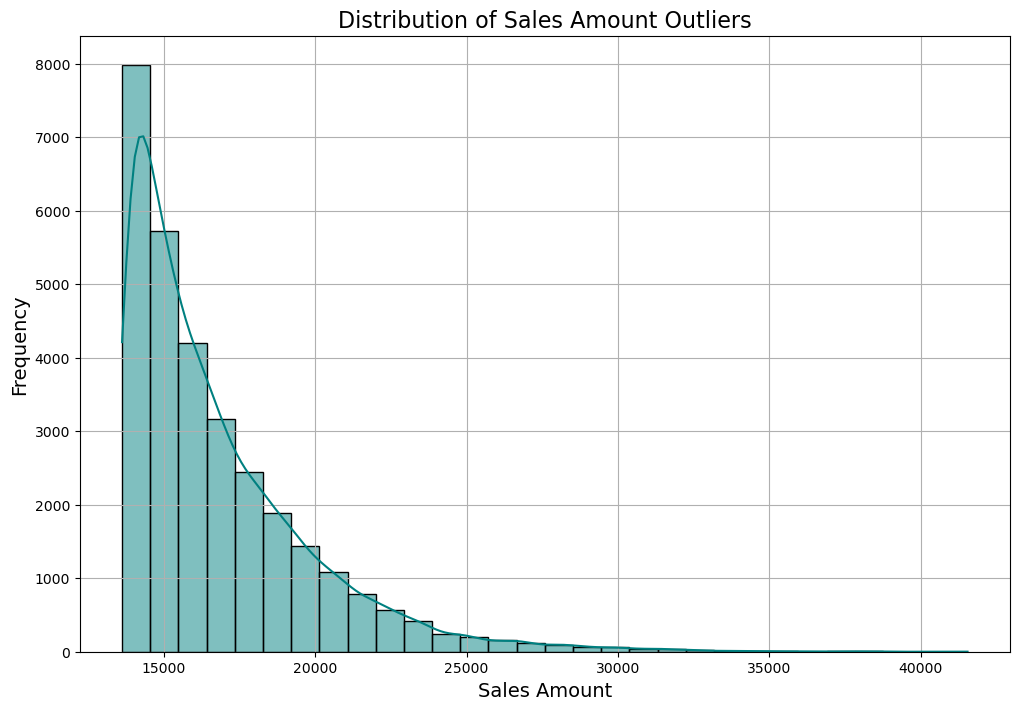

In [79]:
# Outlier removal

percentile25 = df1["Sales"].quantile(0.25)
percentile75 = df1["Sales"].quantile(0.75)

iqr = percentile75-percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

df_outliers=df1[(df1["Sales"] < lower_limit) | (df1["Sales"] > upper_limit)]
print(f'Total number of Outliers present in the Sales column are {len(df_outliers)}.')

# Plotting the outlier distribution
plt.figure(figsize=(12, 8))
sns.histplot(df_outliers["Sales"], kde=True, color='teal', bins=30, edgecolor='black').set(title='Outliers Distribution')
plt.xlabel('Sales Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sales Amount Outliers', fontsize=16)
plt.grid(True)
plt.show()

In [216]:
categorical_cols=[  "Assortment", "StoreType"]
df1=pd.get_dummies(df1, columns=categorical_cols, drop_first=True)

In [217]:
X_ = df1.copy()
y_ = X_.pop("Sales")

The Mean Absolute Error for the validation set is 730.692069
The Mean Squared Error for the validation set is 1641747.593153
The Root Mean Squared Error for the validation set is 1281.306986
The R^2 for the validation set is 0.889368


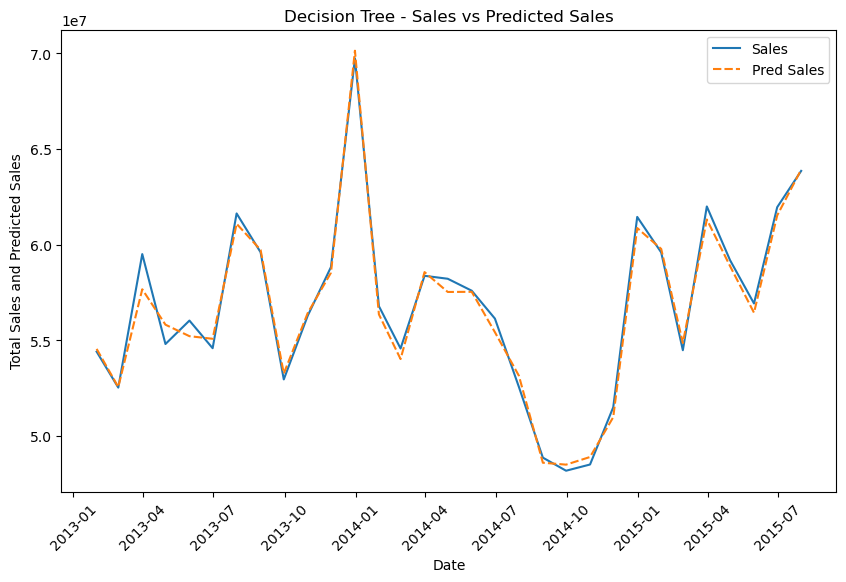

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Decision Tree,6.081028,14122.584034,118.838479,0.999047,730.692069,1.641748e+06,1281.306986


In [218]:
model_and_evaluation("Decision Tree",dt_basic, X_, y_)

The Mean Absolute Error for the validation set is 568.693323
The Mean Squared Error for the validation set is 961523.817517
The Root Mean Squared Error for the validation set is 980.573209
The R^2 for the validation set is 0.935206


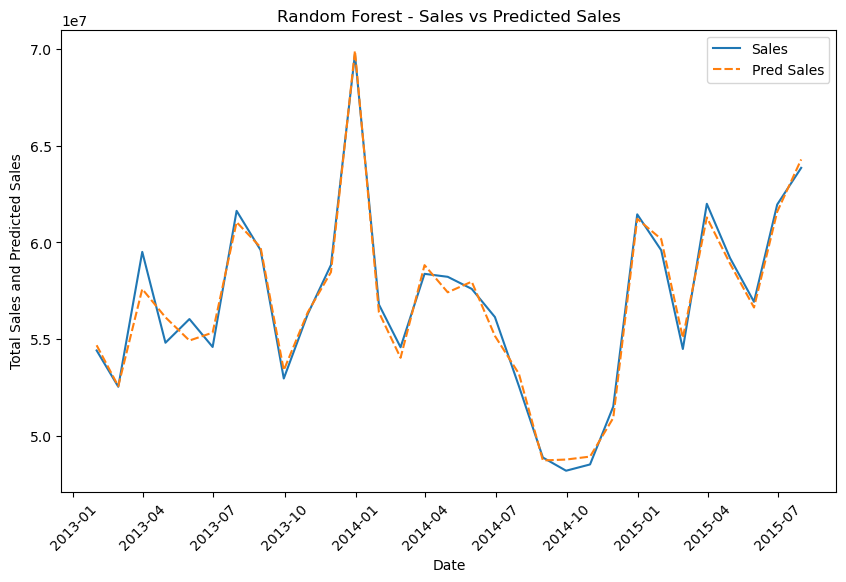

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE
0,Random Forest,213.195983,143184.00273,378.396621,0.990335,568.693323,961523.817517,980.573209


In [178]:
model_and_evaluation("Random Forest",rf, X_, y_)